Ben: The relevant functions for doing the interpolation are kernel() and gp_predict() found here:
https://github.com/benjaminlackey/gpsurrogate/blob/master/notebooks/EOB/LalsuiteSurrogate.ipynb
They take in arrays and return scalars.

* The output of gp_predict() are the amplitude and phase at the EI nodes
* Dot these into the amplitude and phase bases that should also be in the HDF5 file
* To obtain the waveform need the TF2 waveform: [taylorf2.py](https://github.com/benjaminlackey/gpsurrogate/blob/master/src/taylorf2.py)
* Take a look at the surrogate class: surrogate.py
  - See [reconstruct_amp_phase_difference()](https://github.com/benjaminlackey/gpsurrogate/blob/master/src/surrogate.py#L142)


```
    namp_nodes = len(damp_gp_list)
    nphase_nodes = len(dphase_gp_list)

    # Calculate waveform at nodes
    amp_at_nodes = np.array([damp_gp_list[j].predict(np.atleast_2d(params))[0] for j in range(namp_nodes)])
    phase_at_nodes = np.array([dphase_gp_list[j].predict(np.atleast_2d(params))[0] for j in range(nphase_nodes)])

    # Get complex version of B_j's in array form
    Bamp_j_array = np.array([Bamp_j[j].amp for j in range(namp_nodes)])
    Bphase_j_array = np.array([Bphase_j[j].phase for j in range(nphase_nodes)])

    # Evaluate waveform
    amp_interp = np.dot(amp_at_nodes, Bamp_j_array)
    phase_interp = np.dot(phase_at_nodes, Bphase_j_array)

    # Rewrite as TimeDomainWaveform
    xarr = Bamp_j[0].x
    return wave.Waveform.from_amp_phase(xarr, amp_interp, phase_interp)
```


Also
```
    jmax = len(B_j)
    eps_f_j = np.array([gp_list[j].predict(np.atleast_2d(point), return_std=True)[1][0] 
                        for j in range(jmax)])
    
    # Get complex version of B_j's in array form
    if data=='amp':
        B_j_array = np.array([B_j[j].amp for j in range(jmax)])
    elif data=='phase':
        B_j_array = np.array([B_j[j].phase for j in range(jmax)])
    else:
        raise Exception

    # Evaluate waveform
    error_arr = np.dot(eps_f_j, B_j_array)

    # Rewrite as TimeDomainWaveform
    xarr = B_j[0].x
    return xarr, error_arr

```

Check all hdf5 groups and attributes with:

h5dump -n 1 lalsuitetest.hdf5

This prints the description attribute:

h5dump -a description lalsuitetest.hdf5 

In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.set_printoptions(precision=6, linewidth=110)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import h5py

In [3]:
sys.path.insert(0, '../../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2 as f2
import gaussianprocessregression as gpr
import designofexperiment as doe
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics
import uncertaintysampling as us

import lal
import lalsimulation as LS

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(f2)
imp.reload(gpr)
imp.reload(doe)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)
imp.reload(us)

import lalsimulation
reload(lalsimulation)
import lalsimulation as LS

import constants
imp.reload(constants)
from constants import *

__init__: Setting weave cache to /var/folders/8s/kg3qdn9s10v11v8zq2fgf94h0000gn/T/501_python27_compiled/f26702/f26702be568e3c613857548d8158e9baa1c66daf


# Construct surrogate in way that can be directly converted to lalsuite code

In [5]:
def kernel(x1, x2, hyperparams):
    """Matern covariance function for n-dimensional data.
    
    Parameters
    ----------
    x1 : array with shape ndim
    x2 : array with shape ndim
    hyperparams : array with shape ndim+2 [sigma_f, ls0, ls1, ..., sigma_n]
        sigma_f : Approximately the range (ymax-ymin) of values that the data takes.
            sigma_f^2 called the signal variance.
        sigma_n : Noise term. The uncertainty in the y values of the data.
        lsi : Length scales for the variation in dimension i.
    
    Returns
    -------
    covariance : float
    """
    sigma_f = hyperparams[0]
    sigma_n = hyperparams[-1]
    ls = hyperparams[1:-1]
    ndim = len(ls)
    
    # Noise nugget for diagonal elements
    if np.array_equal(x1, x2):
        nugget = sigma_n**2
    else:
        nugget = 0.0
    
    # r**2
    rsq = np.sum(np.array([(x1[i]-x2[i])**2 / ls[i]**2 for i in range(ndim)]))
    r = np.sqrt(rsq)
    
    # nu = 5/2 Matern covariance
    matern = (1. + np.sqrt(5.)*r + 5.*r**2/3.) * np.exp(-np.sqrt(5.)*r)
    
    # Full covariance
    # You must include the nugget to agree with scikit-learn when the points x1, x2 are exactly the same
    
#     print "** kernel **"
#     print "x1 =", x1
#     print "x2 =", x2
#     print "ls =", ls
#     print "(x1 - x2) / ls = ", np.array([(x1[i]-x2[i]) / ls[i] for i in range(ndim)])
#     print "r =", r
#     print "eval =", sigma_f**2 * matern + nugget
    
    return sigma_f**2 * matern + nugget

In [6]:
def gp_predict(xst, hyperparams, x_train, Kinv_dot_y):
    """Interpolate the function at the point xst using Gaussian process regression.
    
    Parameters
    ----------
    xst : array of shape ndim.
        Point x_* where you want to evaluate the function.
    hyperparams : array with shape ndim+2 [sigma_f, ls0, ls1, ..., sigma_n].
        Hyperparameters for the GPR kernel.
    x_train : array of shape (n_train, ndim).
        Training set points.
    Kinv_dot_y : array of shape n_train.
        The interpolating weights at each training set point.
    
    Returns
    -------
    yst : float
        Interpolated value at the point xst.
    """
    # Evaluate vector K_*
    Kst = np.array([kernel(xst, x, hyperparams) for x in x_train])
#     print 'Kst', Kst
#     print 'Kinv_dot_y', Kinv_dot_y[:]

    # Evaluate y_*
    return np.dot(Kst, Kinv_dot_y)

In [6]:
def extract_data_from_scikit_learn(gp):
    """Extract the data in the scikit-learn GaussianProcessRegressor class 
    that you need for the lalsuite version.
    """
    # hyperparams = np.array([sigma_f, lq, ls1, ls2, llam1, llam2, sigma_n])
    hyperparams = gpr.get_hyperparameters(gp)
    
    # The training data
    x_train = gp.X_train_
    y_train = gp.y_train_
    
    # Evaluate K
    K = np.array([[kernel(x1, x2, hyperparams) for x2 in x_train] for x1 in x_train])
    
    # Evaluate K^{-1}
    Kinv = np.linalg.inv(K)
    
    # Evaluate (K^{-1})_{ij} y_j (array of length nparams).
    Kinv_dot_y = np.dot(Kinv, y_train)
    
    return hyperparams, x_train, Kinv_dot_y

# Load scikit-learn (python) version of surrogate

In [45]:
Bamp_filename = '../../data/teobtest40hz/B_amp_corners_lhd.hdf5'
Bphase_filename = '../../data/teobtest40hz/B_phase_corners_lhd.hdf5'
gp_amp_filename = '../../data/teobtest40hz/gp_amp_corners_lhd.hdf5'
gp_phase_filename = '../../data/teobtest40hz/gp_phase_corners_lhd.hdf5'
sur = surrogate.GPSurrogate.load(Bamp_filename, Bphase_filename, gp_amp_filename, gp_phase_filename)

# Bamp_filename = '../../data/teobtest40hz/B_amp_lhd_uncsamp.hdf5'
# Bphase_filename = '../../data/teobtest40hz/B_phase_lhd_uncsamp.hdf5'
# gp_amp_filename = '../../data/teobtest40hz/gp_amp_lhd_uncsamp.hdf5'
# gp_phase_filename = '../../data/teobtest40hz/gp_phase_lhd_uncsamp.hdf5'
# sur = surrogate.GPSurrogate.load(Bamp_filename, Bphase_filename, gp_amp_filename, gp_phase_filename)

In [46]:
#Random point:
#x = np.array([0.8, 0.2, 0.1, 1000, 2000])

# Point exactly in training set:
x = np.array([3.333333e-01, -4.000000e-01, -4.000000e-01, 1.000000e-01, 1.000000e-01])

for i in range(len(sur.dphase_gp_list)):
    gp = sur.dphase_gp_list[i]
    #gp = sur.dphase_gp_list[0]
    hyperparams, x_train, Kinv_dot_y = extract_data_from_scikit_learn(gp)

    a = gp.predict(np.atleast_2d(x))[0]
    b = gp_predict(x, hyperparams, x_train, Kinv_dot_y)

    #sigma_n = hyperparams[-1]
    #print sigma_n
    print np.abs(b/a-1.)

5.53723478181e-09
6.42491049252e-09
1.96401661601e-09
5.68317459759e-09
4.66294558521e-09
2.28728636031e-09
2.02868855048e-09
2.36434094525e-10
1.48636081221e-09
2.49062059865e-09
4.93199625584e-09
1.76905234905e-09
3.07067204997e-09
1.08489428552e-09
4.44460579452e-10
2.02839578467e-09
3.19912274449e-09
3.97346355818e-09
1.37696076763e-09
3.79370002079e-09


# Generate hdf5 file for lalsuite version

In [139]:
def lalsuite_surrogate_format(filename, sur):
    """Write data to an hdf5 file format that can be read by the 
    lalsuite version of the code.
    """
    f = h5py.File(filename, libver='latest')
    
    namp = len(sur.Bamp)
    nphase = len(sur.Bphase)
    
    f.attrs['description'] = \
'''
********************************************************************************
Data for TEOBv4_ROM reduced order model (aligned-spin BNS with tidal interactions).

See B. Lackey, et al. arXiv:xxxx.xxxx.

Parameter ranges:
* 1/3 <= q <= 1
* -0.4 <= spin_1z <= 0.4
* -0.4 <= spin_2z <= 0.4
* 0.1 <= lambda_1 <= 3000
* 0.1 <= lambda_2 <= 3000
* flow >= xxHz

This ROM was built using the TEOBv4 waveform.

The hyperparameters for the Gaussian process regression associated with each 
basis function are listed in the order
[sigma_f, l_q, l_spin1z, l_spin2z, l_lambda1, l_lambda2, sigma_n]
where sigma_f is approximately the function range, sigma_n is the noise/tollerance, 
and l_i is the correlation length scale for the parameter i.
********************************************************************************
'''
    
    # Frequency samples
    f['mf'] = sur.mf
    
    # Training set samples.
    # They are the same for all basis functions so pick amp_0
    gp = sur.damp_gp_list[0]
    x_train = gp.X_train_
    f['x_train'] = x_train
    
    print 'Writing amplitude bases...'
    for i in range(namp):
        print i,
        groupname = 'delta_ln_a_' + str(i)
        group = f.create_group(groupname)
        
        group.attrs['mf_node'] = sur.mf_amp[i]
        group['basis'] = sur.Bamp[i].amp
    
        gp = sur.damp_gp_list[i]
        hyperparameters, x_train, kinv_dot_y = extract_data_from_scikit_learn(gp)
        group['hyperparameters'] = hyperparameters
        group['kinv_dot_y'] = kinv_dot_y
        
    print '\nWriting phase bases...'
    for i in range(nphase):
        print i,
        groupname = 'delta_phi_' + str(i)
        group = f.create_group(groupname)
        
        group.attrs['mf_node'] = sur.mf_phase[i]
        group['basis'] = sur.Bphase[i].phase
        
        gp = sur.dphase_gp_list[i]
        hyperparameters, x_train, kinv_dot_y = extract_data_from_scikit_learn(gp)
        group['hyperparameters'] = hyperparameters
        group['kinv_dot_y'] = kinv_dot_y
        
    f.close()

In [140]:
filename = 'lalsuitetest.hdf5'
lalsuite_surrogate_format(filename, sur)

Writing amplitude bases...
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Writing phase bases...
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19


## Testing

In [141]:
f = h5py.File(filename, libver='latest')

In [142]:
print f['mf'][:].shape
print f['x_train'][:].shape

(10000,)
(159, 5)


In [143]:
print f['delta_ln_a_19'].attrs['mf_node']
print f['delta_ln_a_19/hyperparameters'][:]
print f['delta_ln_a_19/kinv_dot_y'][:]
print f['delta_ln_a_19/basis'][:]

0.03
[  1.244054e+00   5.415526e-01   2.404507e+00   3.200000e+00   1.210941e+03   6.054942e+03   1.816954e-02]
[  1.353636e-01  -2.426995e+00   1.238622e+00   2.569431e+00   3.361933e+00   1.419202e+01  -3.627787e+00
  -8.324047e-01  -1.272532e-01  -3.368970e+01  -2.408338e+00  -1.902484e+00   5.119303e+00   4.062834e+00
   1.460107e+00   3.370889e-01  -2.491526e+00   5.354783e+00   7.465732e-01   4.420478e+01   3.176610e+00
  -5.925059e+00   1.808938e+00  -1.110560e+01   5.000668e+00   6.217673e+00   4.195432e+00  -1.312605e+01
   2.338496e-01   5.919319e+00  -5.379469e+00   1.755869e+01  -1.626893e+01   1.689817e+01  -1.431328e+01
  -1.971245e+01   4.480975e+00   3.670967e+00  -8.873717e+00  -3.385341e+00   6.651964e+00  -8.662202e+00
   8.775134e+00   1.007829e+01   6.649881e+00   3.344075e+00  -4.441547e+00   4.264576e+00  -4.622621e+01
   2.691734e+00  -5.929247e+00   1.690460e+01  -3.125132e+00  -6.299917e+00  -6.306608e+00   1.515829e+00
  -2.227001e+00   7.702309e+00  -3.24518

In [144]:
print f['delta_phi_19'].attrs['mf_node']
print f['delta_phi_19/hyperparameters'][:]
print f['delta_phi_19/kinv_dot_y'][:]
print f['delta_phi_19/basis'][:]

0.03
[  4.255004e+02   1.421491e+00   8.000000e+00   8.000000e+00   8.187851e+03   2.999900e+04   5.062750e-04]
[ 0.161461  0.096188  0.054938  0.327947  0.020727  0.155349 -0.008214 -0.051078  0.235633 -1.000358 -0.042436
 -0.307369  0.988341  0.073701 -0.252881 -0.108205  0.246872  0.052102  0.069441  0.30316  -0.022522 -0.11242
  0.059793 -0.139292  0.20552   0.93233   0.06626  -0.077352  0.774753 -0.627922  0.019855 -0.027874 -0.483242
  0.005088 -0.785822  0.01263   0.400281 -0.800456 -0.580188 -0.260387  0.319411 -0.537523 -0.132596  1.483104
  0.070138 -0.224954 -0.858842  0.713094 -0.410665  0.833558 -0.047864  1.206982 -0.867527 -0.117764  0.446977
  0.055848 -0.876076  0.164289 -0.036691 -0.899262  0.083572  0.165041  0.863735  0.356303 -1.582601  2.375573
  0.56885  -0.553988  0.031443  0.069171  0.268207 -0.297621 -1.257951  0.369415 -0.753824 -0.027229 -0.904814
  0.22315  -0.271993  0.689553  0.709485 -0.88239  -0.703084 -0.80746  -0.595217  0.274676 -0.718739 -0.869145
 

In [145]:
f.close()

# Test code using lalsimulation HDF5 data

The output of the lalsimulation code has to agree with the output of the code below.

In [7]:
filename = 'lalsuitetest.hdf5'
f = h5py.File(filename, 'r')

File structure:

    'mf'
    'x_train'
    'delta_ln_a_i': 'basis', 'hyperparameters', 'kinv_dot_y'
    'delta_phi_i': 'basis', 'hyperparameters', 'kinv_dot_y'
    
i.e. 'hyperparameters', 'kinv_dot_y' are different for each amplitude and phase coefficient gp fit and 'basis' gives the i-th basis function

* There could be an attribute in the HDF5 file telling us how many amplitude and phase coefficients there are in total. Although we could query this.

* There are 10000 points in mf. Isn't this overkill? Also, how were these points chosen? MP thinks that a few hundred points should suffice. Interpolation in frequency needs to be done at any rate since the user can specify Deltaf freely. Presumably this interpolation of the fully assembled amplitude and phase in frequency should be done by some sort of spline.

In [21]:
# Compute amplitude and phase coefficients for an example point

# Point exactly in training set:
x = np.array([3.333333e-01, -4.000000e-01, -4.000000e-01, 1.000000e-01, 1.000000e-01])

n = 20 # FIXME: should be read from an attribute
for i in range(n):
    grp_ln_a = f['delta_ln_a_%d'%i]
    grp_phi = f['delta_phi_%d'%i]
    print gp_predict(x, grp_ln_a['hyperparameters'], f['x_train'], grp_ln_a['kinv_dot_y']), gp_predict(x, grp_phi['hyperparameters'], f['x_train'], grp_phi['kinv_dot_y'])

-0.0873621747291 2.67268739046
-0.127697708695 8.04386720647
-0.142636962932 19.6197273431
-0.150228252721 20.5559015819
-0.157051635052 24.9972548013
-0.162628411644 26.1481786918
-0.183240290086 27.5302242225
-0.20070751982 28.8042031484
-0.218269466269 30.1149581712
-0.23251895837 33.2215152853
-0.246764670981 35.2173137722
-0.289641481501 37.6413768021
-0.302604115733 40.1108972129
-0.338274141305 42.9222709187
-0.381038556706 47.6703481679
-0.429119310859 55.3266617441
-0.476853385203 62.517613797
-0.544626065822 72.5862838226
-0.52161738489 80.1487817264
-0.473509283346 85.0782840175


In [8]:
# Compute amplitude and phase coefficients for an example point

# Point exactly in training set:
x = np.array([3.333333e-01, -4.000000e-01, -4.000000e-01, 1.000000e-01, 1.000000e-01])

n = 20 # FIXME: should be read from an attribute

# Calculate waveform at nodes
amp_at_nodes = np.array([gp_predict(x, 
                                    f['delta_ln_a_%d/hyperparameters'%i], 
                                    f['x_train'], 
                                    f['delta_ln_a_%d/kinv_dot_y'%i]) 
                         for i in range(n)])

phase_at_nodes = np.array([gp_predict(x, 
                                      f['delta_phi_%d/hyperparameters'%i], 
                                      f['x_train'], 
                                      f['delta_phi_%d/kinv_dot_y'%i]) 
                           for i in range(n)])

In [9]:
# Get arrays of amplitude and phase bases
Bamp_j_array = np.array([f['delta_ln_a_%d/basis'%i][:] for i in range(n)])
Bphase_j_array = np.array([f['delta_phi_%d/basis'%i][:] for i in range(n)])

In [10]:
# Evaluate waveform
amp_interp = np.dot(amp_at_nodes, Bamp_j_array)
phase_interp = np.dot(phase_at_nodes, Bphase_j_array)

In [18]:
amp_interp

array([-0.019851, -0.019857, -0.019863, ..., -0.474016, -0.473763, -0.473509])

In [11]:
phase_interp

array([  0.000000e+00,   1.056314e-03,   2.112993e-03, ...,   8.503017e+01,   8.505423e+01,   8.507828e+01])

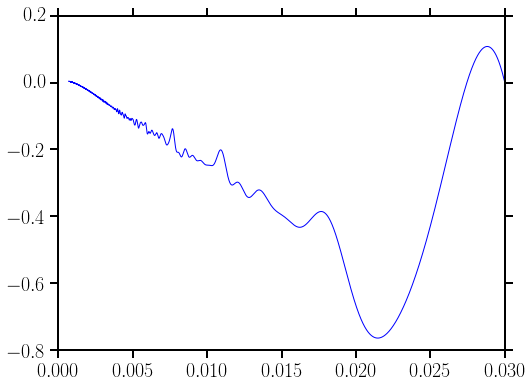

In [14]:
plt.plot(f['mf'], amp_interp)

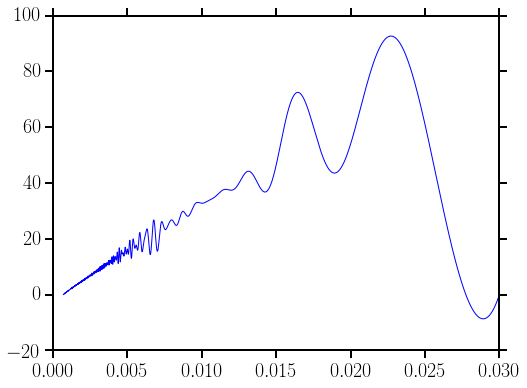

In [44]:
plt.plot(f['mf'], phase_interp)

In [48]:
import taylorf2

def geometric_reference_waveform(params, mf):
    """Reference TaylorF2 waveform in geometric units
    evaluated at the same times as the surrogate of the difference.
    """
    q, s1, s2, lambda1, lambda2 = params
    h_ref = taylorf2.dimensionless_taylorf2_waveform(
        mf=mf, q=q,
        spin1z=s1, spin2z=s2,
        lambda1=lambda1, lambda2=lambda2)

    # Reference waveform has zero starting phase
    h_ref.add_phase(remove_start_phase=True)
    return h_ref

In [51]:
# Compute TaylorF2 reference waveform
h_ref = geometric_reference_waveform(x, f['mf'][:])

In [55]:
# Surrogate of A and \Phi
h_sur = h_ref.copy()
h_sur.amp *= np.exp(amp_interp)
h_sur.phase += phase_interp

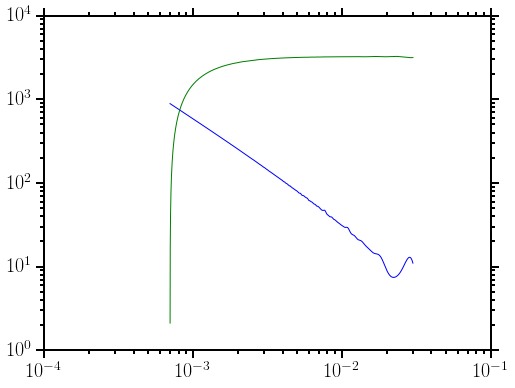

In [59]:
loglog(h_sur.x, h_sur.amp)
loglog(h_sur.x, h_sur.phase)

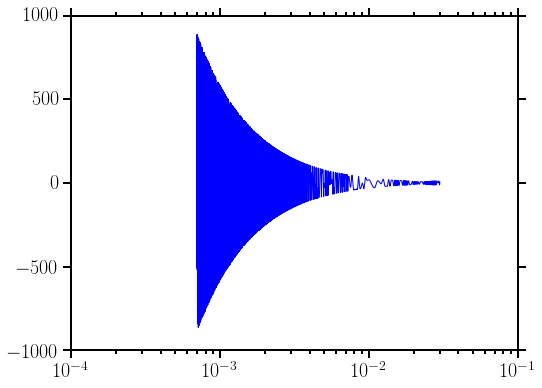

In [62]:
semilogx(h_sur.x, h_sur.amp * np.exp(1j * h_sur.phase))

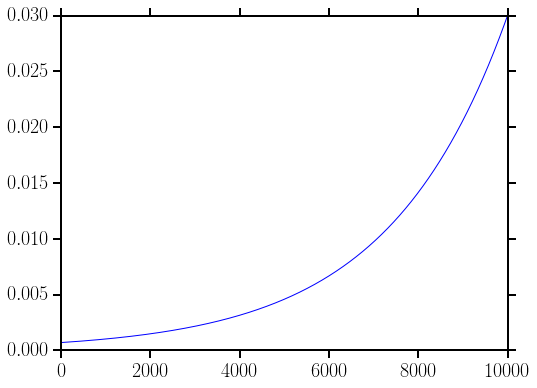

In [63]:
plot(f['mf'])

## Save matrix data

Make it easier to read the surrogate data in C

* To make the C code easier store for amplitude and phase:
    * hyperparameters as a matrix (n_EI_nodes, n_hyp)
    * kinv_dot_y as a matrix (n_EI_nodes, n_train)
    * bases as a matrix (n_EI_nodes, n_freqs)
    * EI_nodes (n_EI_nodes)


In [23]:
# Read the current HDF5 format
n_EI_nodes = 20
n_train = 159

hyp_amp = np.array([f['delta_ln_a_%d/hyperparameters'%i][:] for i in range(n_EI_nodes)])
hyp_phi = np.array([f['delta_phi_%d/hyperparameters'%i][:] for i in range(n_EI_nodes)])

kinv_dot_y_amp = np.array([f['delta_ln_a_%d/kinv_dot_y'%i][:] for i in range(n_EI_nodes)])
kinv_dot_y_phi = np.array([f['delta_phi_%d/kinv_dot_y'%i][:] for i in range(n_EI_nodes)])

B_amp = np.array([f['delta_ln_a_%d/basis'%i][:] for i in range(n_EI_nodes)])
B_phi = np.array([f['delta_phi_%d/basis'%i][:] for i in range(n_EI_nodes)])

EI_nodes_amp = np.array([f['delta_ln_a_%d'%i].attrs['mf_node'] for i in range(n_EI_nodes)])
EI_nodes_phi = np.array([f['delta_phi_%d'%i].attrs['mf_node'] for i in range(n_EI_nodes)])


# Save data to new HDF5 file
fp = h5py.File('lalsuitetest_new.hdf5', 'w')
# Copy some datasets
fp.attrs['description'] = f.attrs['description']
fp['mf'] = f['mf'][:]
fp['x_train'] = f['x_train'][:]
# Save matrix data
fp['hyp_amp'] = hyp_amp
fp['hyp_phi'] = hyp_phi
fp['kinv_dot_y_amp'] = kinv_dot_y_amp
fp['kinv_dot_y_phi'] = kinv_dot_y_phi
fp['B_amp'] = B_amp
fp['B_phi'] = B_phi
fp['EI_nodes_amp'] = EI_nodes_amp
fp['EI_nodes_phi'] = EI_nodes_phi
fp.close()

## Ongoing testing of C code

In [4]:
phiRef, deltaF, fLow, fHigh, fRef, distance, inclination = 0, 0.1, 20, 0, 20, 1, 0
m1SI, m2SI, chi1, chi2, lambda1, lambda2, nk_max = 30*lal.MSUN_SI, 10*lal.MSUN_SI, -0.4, -0.4, 0.1, 0.1, -1

hp, hc = LS.SimIMRTEOBv4ROM(phiRef, deltaF, fLow, fHigh, fRef, distance, inclination, 
                m1SI, m2SI, chi1, chi2, lambda1, lambda2, nk_max)

* Use Ben's updated HDF5 file: TEOBv4_ROM.hdf5
* Implement checks on parameter bounds
* Implement checks on dataset sizes? Remove all hardwired sizes.